### evaluate a pit model by draw prediction visually for a long horizon

MLP-pitmodel-v4


base: 11./evaluate_model_visualdraw

+ visualization of pitagemodel



In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import indycar.model.evaluate_fulltest_fastrun_paper as ev

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


## Load Data

In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

#### evaluate

In [3]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        
        
        
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        

        #axs.set_xlim((80,110))
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        
        if outputfile != '':
            plt.savefig(outputfile + '-%d.pdf'%idx)
        
        # set the x ticks
        #xtickslocs = plt.gca().get_xticks()
        #print(xtickslocs)
        #ticks = [tick for tick in plt.gca().get_xticklabels()]
        #print(ticks)        
        
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 10)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)
        
        
        
        
        plt.show()
        


In [4]:
import pickle
def savedata(datafile,dfs):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = dfs
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
        
def loaddata(datafile):
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        return dfout        

In [16]:
def long_predict_bymloutput(output, dfin):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 2
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values[0]
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

In [5]:
# construct long prediction result


def plot_forecasts_h(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        ax = plt.subplot(figcnt, 1, idx+1)
        #ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
    plt.show()

    
    
def plot_forecasts(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(4*figcnt,3))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        #ax = plt.subplot(figcnt, 1, idx+1)
        ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+80,xl+110))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        ax.set_ylim((-5,+23))
        
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '-%d.pdf'%0)
    
def plot_forecast_singles(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet'],
                    xlim_l=80, xlim_h=110):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    #fig, axs = plt.subplots(1, figcnt, figsize=(4*figcnt,3))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(4,3))
        #ax = plt.subplot(figcnt, 1, idx+1)
        ax = plt.subplot(1, 1, 1)
        
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+xlim_l,xl+xlim_h))
        #ax.set_xlim((xl+79,xl+109))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        ax.set_ylim((-2,+26))
        
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
        plt.show()
        fig.tight_layout()
        fig.savefig(outputfile + '-%d.pdf'%(idx+1))    

### evaluate

In [6]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}


In [7]:
prediction_length = 2
freq = '1min'

In [8]:
ev._dataset_id = 'indy2013-2018-nocarid'
ev._dataset_id = 'indy2013-2018'
#_test_event = 'Indy500-2019'
ev._test_event = 'Indy500-2018'

ev._task_id = 'rank'  # rank,laptime, the trained model's task
ev._run_ts = ev.COL_RANK   #COL_LAPTIME,COL_RANK
ev._exp_id='rank'  #rank, laptime, laptim2rank, timediff2rank... 

ev._feature_mode = ev.FEATURE_STATUS
ev._context_ratio = 0.

ev.init()

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/evaluate_fulltest_fastrun_paper.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/evaluate_fulltest_fastrun_paper.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


In [9]:
test_cars = [12]
save_prefix = 'test-' + ev._test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'

In [10]:
train_ds, test_ds,_,_ = ev.make_dataset_byevent(events_id[ev._test_event], prediction_length,freq, 
                                     oracle_mode=ev.MODE_ORACLE,
                                     run_ts = ev._run_ts,
                                     test_event = ev._test_event,
                                     test_cars=test_cars,
                                     half_moving_win = 0,
                                     train_ratio = 0.4)


train len:0, test len:188, mae_track:0.0,mae_lap:0.0,


### load model from dfout

In [12]:
def load_dfout(datafile):
    #with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        
        return dfout[0]

In [13]:
### load ml models
_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''
outfile=f'shortterm-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-rerank-t{_trim}.pickle'
preddf = load_dfout(outfile)

outfile=f'shortterm-dfout-ranknet-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}.pickle'
oracle_df = load_dfout(outfile)

#ranknet
outfile='../result/22.PaperFinal/shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
#outfile='shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
data = load_dfout(outfile)
ranknet_df, acc, ret = data

In [14]:
df = preddf['2018']['rf']
dfin = df[df['carno']==test_cars[0]]

In [15]:
dfin.head(2)

,carno,startlap,startrank,endrank,pred_endrank,diff,sign,pred_diff,pred_sign
7,12.0,9.0,2.0,2.0,12.0,0.0,0.0,10.0,1.0
40,12.0,10.0,2.0,2.0,12.0,0.0,0.0,10.0,1.0


In [17]:
len(dfin)

188

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)


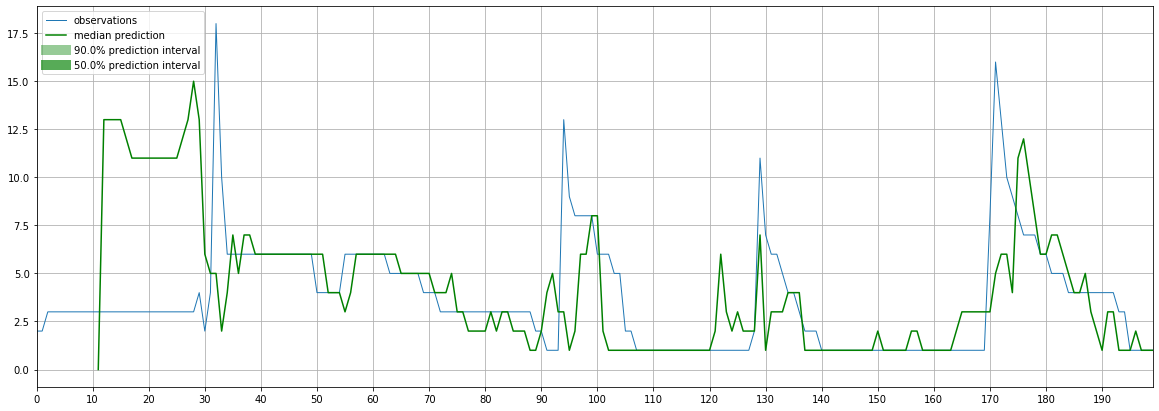

In [18]:
df = preddf['2018']['rf']
dfin = df[df['carno']==test_cars[0]]
predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
target, tss = long_predict_bymloutput('', dfin)
plot_prob_forecasts_ex([tss],[target],'')

In [19]:
tss_template = tss

### multi draw

In [39]:
#xgb
df = preddf['2018']['xgb']
dfin_xgb = df[df['carno']==test_cars[0]]
target_xgb, tss_xgb = long_predict_bymloutput('xgb-rank', dfin_xgb)

#xgb
df = preddf['2018']['svr']
dfin_svr = df[df['carno']==test_cars[0]]
target_svr, tss_svr = long_predict_bymloutput('svr-rank', dfin_svr)

#rf
df = preddf['2018']['rf']
dfin_rf = df[df['carno']==test_cars[0]]
target_rf, tss_rf = long_predict_bymloutput('rf-rank', dfin_rf)


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)


xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)
xlim: (25771680.0, 25771879.0)
ylim: (-10.5489670753479, 23.795226764678954)


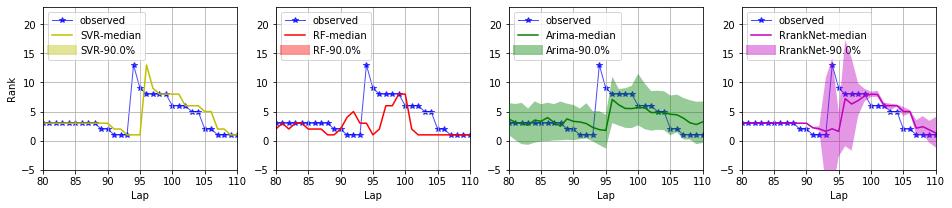

In [42]:
plot_forecasts(tss_arima, [target_svr, target_rf,target_arima, target_oracle],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

In [52]:
savedata('Fig3-RankNet-Oracle.pickle',[tss_arima, target_svr, target_rf,target_arima, target_oracle])

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)
xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


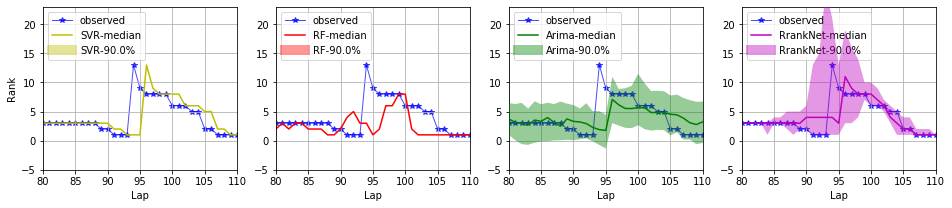

In [44]:
plot_forecasts(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

In [53]:
savedata('Fig3-RankNet-MLP.pickle',[tss_arima, target_svr, target_rf,target_arima, target_ranknet_1run])

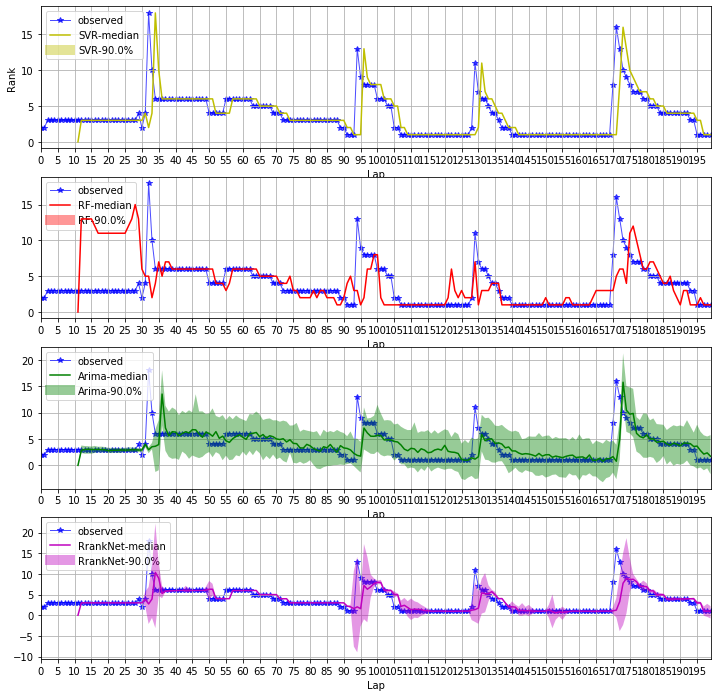

In [50]:
plot_forecasts_h(tss_arima, [target_svr, target_rf,target_arima, target_oracle],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

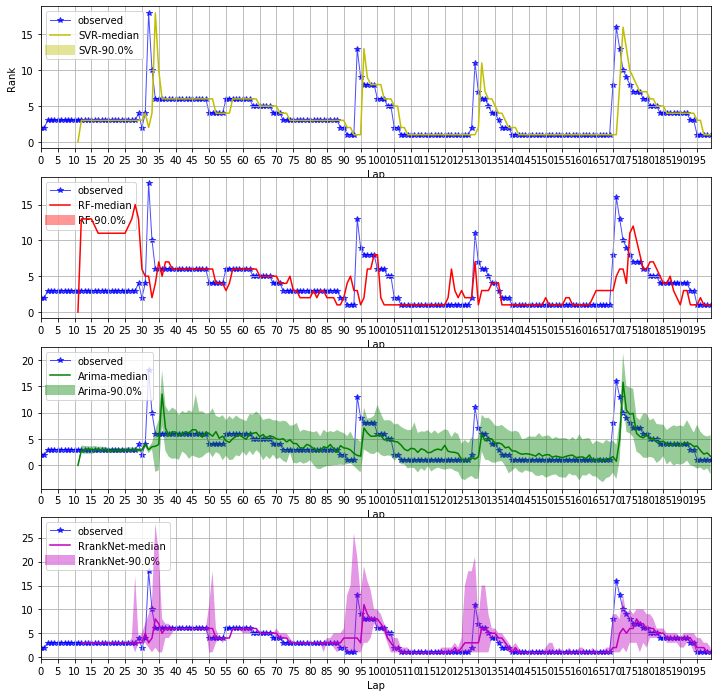

In [51]:
plot_forecasts_h(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

### test ranknet

In [ ]:
#ranknet
outfile='../result/22.PaperFinal/shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
data = load_dfout(outfile)
ranknet_df, acc, ret = data



In [26]:
ret['pitmodel-RANK-2018-inlap-nopitage'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [45]:
ret['pitmodel-RANK-2018-inlap-nopitage'][0][1][test_cars[0]]

array([[nan, nan, nan, ...,  1.,  2.,  1.],
       [nan, nan, nan, ...,  1.,  2.,  0.],
       [nan, nan, nan, ...,  1.,  0.,  2.],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  3.,  1.,  0.],
       [nan, nan, nan, ...,  2.,  0.,  0.]])

In [46]:
ret['pitmodel-RANK-2018-inlap-nopitage'][0][2][test_cars[0]]

array([ 1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  3.,  1.,  3., 17.,  9.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.,  3.,
        3.,  3.,  3.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  4.,
        4.,  4.,  4.,  4.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
        0.,  0.,  0., 12.,  8.,  7.,  7.,  7.,  7.,  5.,  5.,  5.,  4.,
        4.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 10.,
        6.,  5.,  5.,  4.,  3.,  3.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  7., 15., 12.,  9.,  8.,  7.,  6.,  6.,  6.,  5.,  5

In [37]:
dfs = []
for id in range(100):
    df = ret['pitmodel-RANK-2018-inlap-nopitage'][id][0]
    df = df[df['carno']==test_cars[0]]
    dfs.append(df)
    
dfin_ranknet = pd.concat(dfs)

In [38]:
dfin_ranknet

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
7,12,10,2.0,2.0,0.0,0,2.0,0.0,0
40,12,11,2.0,2.0,0.0,0,2.0,0.0,0
73,12,12,2.0,2.0,0.0,0,2.0,0.0,0
106,12,13,2.0,2.0,0.0,0,2.0,0.0,0
139,12,14,2.0,2.0,0.0,0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...
5236,12,193,2.0,0.0,-2.0,-1,1.0,-1.0,-1
5259,12,194,2.0,0.0,-2.0,-1,2.0,0.0,0
5282,12,195,0.0,0.0,0.0,0,0.0,0.0,0
5305,12,196,0.0,0.0,0.0,0,0.0,0.0,0


In [39]:
target_ranknet, tss_ranknet = long_predict_bymloutput('ranknet-rank', dfin_ranknet)

tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


In [51]:
#rf
df = preddf['2018']['rf']
dfin_rf = df[df['carno']==test_cars[0]]
target_rf, tss_rf = long_predict_bymloutput('rf-rank', dfin_rf)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)


xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


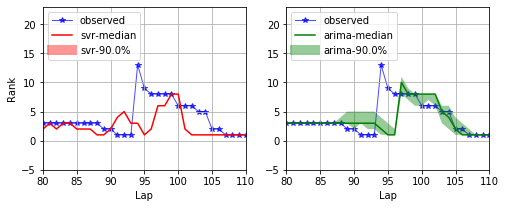

In [42]:
plot_forecasts(tss_rf, [target_rf, target_ranknet], 'ranknet-rf-rank-forecast')

In [58]:
samples = ret['pitmodel-RANK-2018-inlap-nopitage'][0][1][test_cars[0]]
tss  = ret['pitmodel-RANK-2018-inlap-nopitage'][0][2][test_cars[0]]

target_ranknet_1run, tss_ranknet_1run = long_predict_bysamples('ranknet-rank', samples, tss)


tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
target samples shape: (100, 189)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


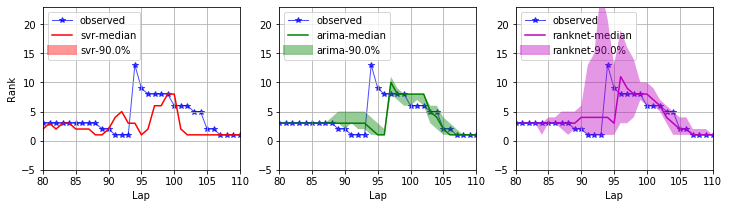

In [59]:
plot_forecasts(tss_rf, [target_rf, target_ranknet,target_ranknet_1run], 'ranknet-rf-rank-forecast')

### draw singles

In [29]:
#savedata('Fig3-RankNet-Oracle.pickle',[tss_arima, target_svr, target_rf,target_arima, target_oracle])
tss_arima, target_svr, target_rf,target_arima, target_oracle = loaddata('Fig3-RankNet-Oracle.pickle')

In [30]:
tss_arima, target_svr, target_rf,target_arima, target_ranknet_1run = loaddata('Fig3-RankNet-MLP.pickle')

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)
xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


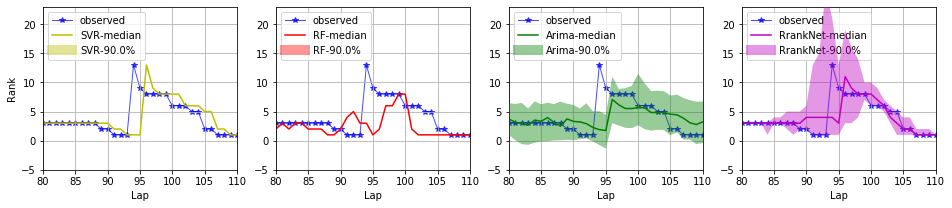

In [31]:
plot_forecasts(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


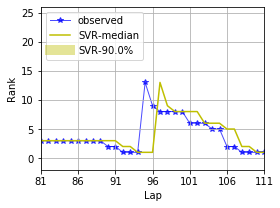

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


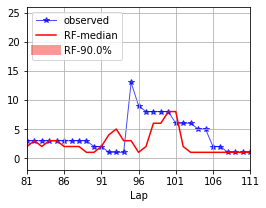

xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)


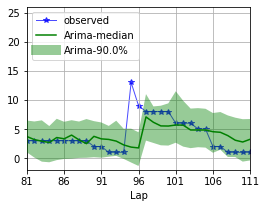

xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


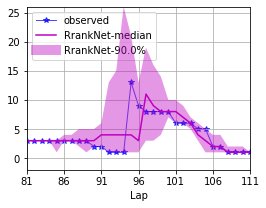

In [32]:
plot_forecast_singles(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


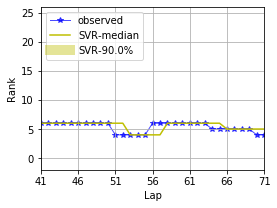

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


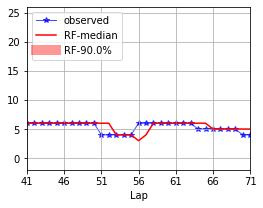

xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)


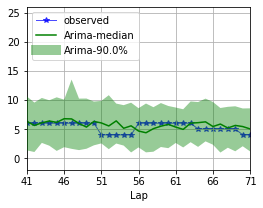

xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


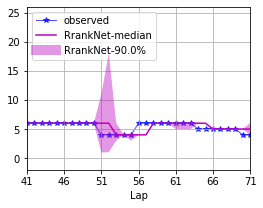

In [39]:
plot_forecast_singles(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast-pit50',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'],
              xlim_l=40,xlim_h=70)

## PitModel dataset

In [310]:
from gluonts.model.forecast import SampleForecast
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
            return 0
                       
    def forecast_ds(self, test_ds, sample_cnt=100):
        """
        test_ds as testset, the unsclaed input
        """
        
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

        #build a new forecasts object
        nf = []
        for idx, rec in enumerate(test_ds):
            
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                onecast[i] = self.predict(feat[0], feat[[1],feat[2]])
        
            nfc = SampleForecast(samples = onecast, 
                                 freq='1min', start_date=start)
            nf.append(nfc)

        return nf
    
    
    def forecast_onecar(self, test_ds, plen = 2, sample_cnt=100):
        """
        the probability of pitstop at plen laps
        long-prediction for a single car, 
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                                                    
                if nextpit == plen:
                    onecast[i, idx + plen] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss
    
    def forecast_onecar_range(self, test_ds, plen = 2, sample_cnt=100):
        """
        the probability of pitstop at plen laps
        long-prediction for a single car, 
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = int(self.predict(*feat))
                                                    
                if nextpit <= plen:
                    onecast[i, idx + nextpit] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss    
    
    def forecast_onecar_lap2nextpit(self, test_ds, sample_cnt=100):
        """
        long-prediction for a single car
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen))
        
        for idx, rec in enumerate(test_ds):
                
            target = rec[0]
            feat = rec[1:]
            
            tss[idx] = target
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                onecast[i, idx] = nextpit
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss    

In [397]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'
testevent = 'Indy500-2018'
#datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps.pickle'
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps-includeend.pickle'

df_train, df_test, events, testevent, _data = loaddata(datafile)
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

In [131]:
prob, pit, fc, target, model = {}, {},{}, {}, {}


In [308]:
def get_predprob_by_model(modelfile, test_ds,plen=2, rangemode=False):
    pitmodel = PitModel()
    pitmodel.load_model(modelfile)
    
    if rangemode == True:
        forecast,targets = pitmodel.forecast_onecar_range(test_ds, plen=plen)
    else:
        forecast,targets = pitmodel.forecast_onecar(test_ds, plen=plen)
    
    

    #fill template
    tss = tss_template.copy()
    for idx in range(len(tss)):
        if idx < len(targets):
            tss.iloc[idx, 0] = targets[idx]
        else:
            tss.iloc[idx, 0] = 0

    #pred
    pred = np.mean(forecast.samples, axis=0)

    #pitstops
    pitidx = np.where(targets==1)
    pits = targets[pitidx]

    x = pitidx[0].reshape(-1)
    y = np.zeros_like(x)
    y = pred[x]
    pitstop = np.array([x+1,y])

    
    x = np.arange(len(pred)) + 1
    y = pred
    probability = np.array([x,y])
    
    return probability, pitstop, forecast, targets, pitmodel

In [305]:
allruns = ['sel','all','noshort']
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds)
    

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
init model:pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


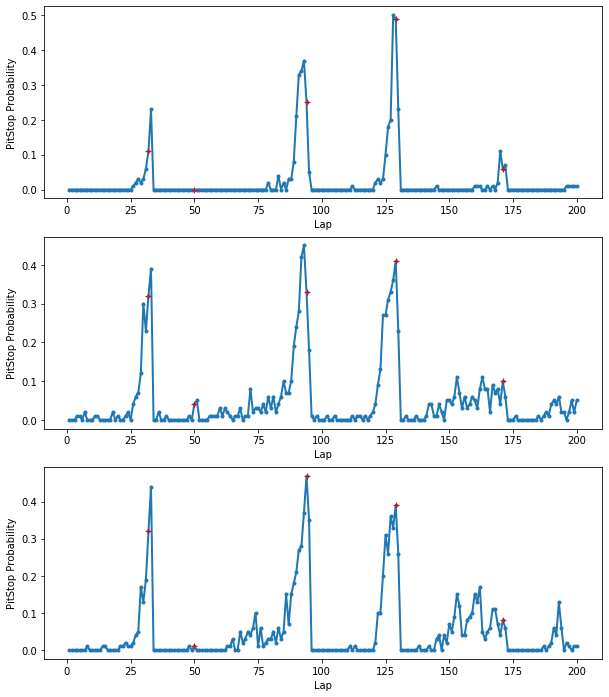

In [134]:
figcnt = len(allruns)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(allruns):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')

In [303]:
rid='dsel'
prob, pit, fc, target, model = {}, {},{}, {}, {}
prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', test_ds[:,:3],plen=6)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle


In [207]:
test_ds.shape

(167, 4)

In [218]:
rid='dsel'
fc[rid].samples[:,26]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [219]:
fc[rid].samples.shape

(100, 167)

In [221]:
np.where(fc[rid].samples[:,:]!=0)

(array([], dtype=int64), array([], dtype=int64))

In [222]:
np.sum(fc[rid].samples)

0.0

In [223]:
fc, ss = model[rid].forecast_onecar_lap2nextpit(test_ds[:,:3])

In [225]:
fc.samples[0,:]

array([28., 27., 26., 25., 24., 23., 22., 22., 21., 20., 19., 18., 17.,
       16., 15., 14., 14., 13., 12., 11., 11., 10.,  9.,  8.,  8.,  7.,
        6.,  5.,  5., 29., 28., 27., 26., 25., 24., 23., 22., 22., 21.,
       20., 19., 18., 17., 16., 15., 14., 14., 13., 12., 11., 11., 10.,
       10.,  9., 29., 29., 29., 29., 29., 28., 26., 25., 24., 23., 23.,
       22., 22., 22., 29., 29., 29., 28., 28., 28., 27., 25., 24., 23.,
       23., 22., 22., 21., 21., 20., 19., 18., 17., 16., 15., 14., 14.,
       13., 12., 11., 11., 10.,  9.,  8.,  8.,  7.,  6.,  6.,  5.,  4.,
       29., 28., 27., 26., 25., 24., 23., 22., 22., 21., 20., 19., 18.,
       17., 16., 15., 14., 14., 14., 14., 13., 13., 13., 12., 12., 11.,
       11., 10., 10.,  9.,  9.,  8.,  8.,  7., 29., 29., 29., 28., 27.,
       27., 27., 26., 25., 24., 23., 22., 22., 20., 19., 19., 18., 17.,
       16., 15., 14., 14., 13., 12., 11., 10., 10.,  9.,  9.])

In [228]:
rid

'dsel'

In [229]:
model[rid].model.keys()

dict_keys(['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10', '0-11', '0-12', '0-13', '0-14', '0-15', '0-16', '0-17', '0-18', '0-19', '0-20', '0-21', '0-22', '0-23', '0-24', '0-25', '0-26', '0-27', '0-28', '0-29', '0-30', '0-31', '0-32', '0-33', '0-34', '0-35', '0-36', '0-37', '0-38', '0-39', '0-40', '0-41', '0-42', '0-43', '0-44', '0-45', '0-46', '0-47', '0-48', '0-49', '0-50', '0-51', '0-52', '0-53', '0-54', '0-55', '0-56', '0-57', '0-58', '0-59', '0-60', '0-61', '0-62', '0-63', '0-64', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17', '1-18', '1-19', '1-20', '1-21', '1-22', '1-23', '1-24', '1-25', '1-26', '1-27', '1-28', '1-29', '1-30', '1-31', '1-32', '1-33', '1-34', '1-35', '1-36', '1-37', '1-38', '1-39', '1-40', '1-41', '1-42', '1-43', '1-44', '1-45', '1-46', '1-47', '1-48', '1-49', '1-50', '1-51', '1-52', '1-53', '1-54', '1-55', '1-56', '1-57', '1-58', '1-59', '1-60', '1-61', 

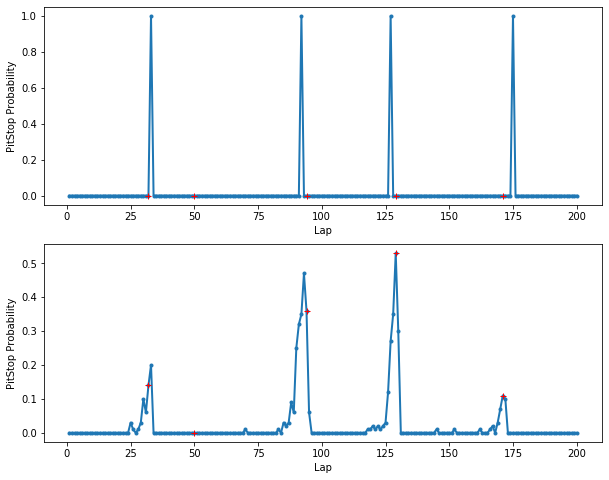

In [306]:
runs=['dsel','sel']
figcnt = len(runs)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(runs):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')

In [353]:
plen=2
rid='dsel-range'
prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', test_ds[:,:3],plen=plen, rangemode=True)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle


In [354]:
allruns = ['sel-range']
rrid = 'sel'
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rrid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds, plen=plen, rangemode=True)
    

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


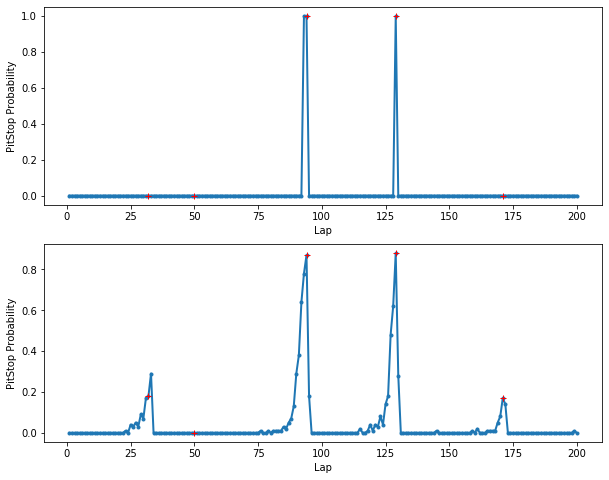

In [355]:
runs=['dsel-range','sel-range']
figcnt = len(runs)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(runs):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')

In [365]:
from sklearn.metrics import f1_score, recall_score

In [375]:
def get_f1(rid, threshold=0.5):
    pred_true = list(np.where(prob[rid][1,:] > threshold)[0])
    print(pred_true)
    truth = (pit[rid][0]-1).astype(int)
    print(truth)
    y_pred = [ 1 if x in pred_true else 0 for x in range(0,200)]
    y_true =[ 1 if x in truth else 0 for x in range(0,200)]
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred)
    
    print('f1:', f1, 'recall', recall)
    return f1, recall

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


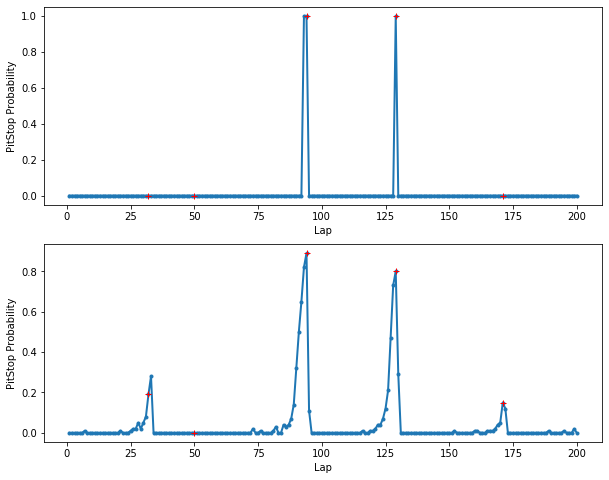

In [368]:
plen=2
rid='dsel-range'
prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', test_ds[:,:3],plen=plen, rangemode=True)
allruns = ['sel-range']
rrid = 'sel'
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rrid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds, plen=plen, rangemode=True)
runs=['dsel-range','sel-range']
figcnt = len(runs)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(runs):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')   


In [370]:
threshold=0.15
get_f1('dsel-range', threshold=threshold)
get_f1('sel-range', threshold=threshold)

[92, 93, 128]
[ 31  49  93 128 170]
f1: 0.7448979591836735 recall 0.4
[31, 32, 89, 90, 91, 92, 93, 125, 126, 127, 128, 129]
[ 31  49  93 128 170]
f1: 0.6621102749193672 recall 0.6


(0.6621102749193672, 0.6)

In [371]:
test_car12 = df_test[df_test['carno']==14]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values


init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


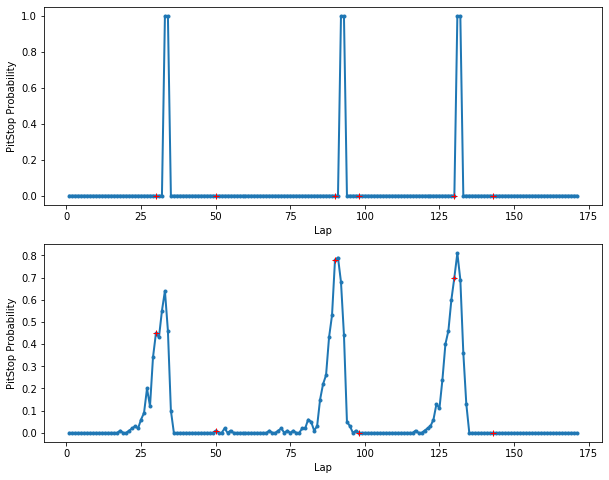

In [376]:
plen=6
rid='dsel-range'
prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', test_ds[:,:3],plen=plen, rangemode=True)
allruns = ['sel-range']
rrid = 'sel'
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rrid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds, plen=plen, rangemode=True)
runs=['dsel-range','sel-range']
figcnt = len(runs)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(runs):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')  

In [377]:
threshold=0.15
get_f1('dsel-range', threshold=threshold)
get_f1('sel-range', threshold=threshold)

[32, 33, 91, 92, 130, 131]
[ 29  49  89  97 129 142]
f1: 0.4845360824742268 recall 0.0
[26, 28, 29, 30, 31, 32, 33, 85, 86, 87, 88, 89, 90, 91, 92, 125, 126, 127, 128, 129, 130, 131, 132]
[ 29  49  89  97 129 142]
f1: 0.5724509712798588 recall 0.5


(0.5724509712798588, 0.5)

In [392]:
def get_predprob_by_pitmodel(pitmodel, test_ds,plen=2, rangemode=False):
    
    if rangemode == True:
        forecast,targets = pitmodel.forecast_onecar_range(test_ds, plen=plen)
    else:
        forecast,targets = pitmodel.forecast_onecar(test_ds, plen=plen)

    #fill template
    tss = tss_template.copy()
    for idx in range(len(tss)):
        if idx < len(targets):
            tss.iloc[idx, 0] = targets[idx]
        else:
            tss.iloc[idx, 0] = 0

    #pred
    pred = np.mean(forecast.samples, axis=0)

    #pitstops
    pitidx = np.where(targets==1)
    pits = targets[pitidx]

    x = pitidx[0].reshape(-1)
    y = np.zeros_like(x)
    y = pred[x]
    pitstop = np.array([x+1,y])

    
    x = np.arange(len(pred)) + 1
    y = pred
    probability = np.array([x,y])
    
    return probability, pitstop, forecast, targets, pitmodel

def get_macro_eval(modelfile, featureCnt, plen=2, threshold=0.5, rangemode=True, normalpit = False):
    pitmodel = PitModel()
    pitmodel.load_model(modelfile)
    
    carlist = set(list(df_test.carno.values))

    ret = []
    for carno in carlist:
        
        if normalpit:
            #use normal pit only
            test_car12 = df_test[(df_test['carno']==carno) & (df_test['pit_oncaution']==0)]
        else:
            test_car12 = df_test[df_test['carno']==carno]
        
        test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

        prob, pit,fc,target,model = get_predprob_by_pitmodel(
            pitmodel, test_ds[:,:featureCnt],plen=plen, rangemode=rangemode)

        pred_true = list(np.where(prob[1,:] > threshold)[0])
        print(pred_true)
        truth = (pit[0]-1).astype(int)
        print(truth)
        y_pred = [ 1 if x in pred_true else 0 for x in range(0,200)]
        y_true =[ 1 if x in truth else 0 for x in range(0,200)]
        f1 = f1_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred)
    
        print('f1:', f1, 'recall', recall)
        ret.append([f1, recall])
        
    #macro mean
    macro_ret = np.mean(np.array(ret), axis=0)
    print('macro ret:', macro_ret)
    
    return ret, macro_ret

In [413]:
cols = ['model','featureCnt','plen','f1','recall']
reteval = []
plen = 2
threshold = 0.15

#paper output
_, ret = get_macro_eval('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle', 3, plen=2, threshold=0.2)
reteval.append(['mlp-sel',3, plen, ret[0], ret[1]])
_, ret = get_macro_eval('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle', 3, plen=2, threshold=0.2)
reteval.append(['mlp-all',3, plen, ret[0], ret[1]])
_, ret = get_macro_eval('pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', 3,plen=2)
reteval.append(['dmlp-sel',3, plen, ret[0], ret[1]])
_, ret = get_macro_eval('pitmodel-m65-dmlp-dall-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', 3,plen=2)
reteval.append(['dmlp-all',3, plen, ret[0], ret[1]])

evaldf_result = pd.DataFrame(data=reteval, columns=cols) 
                

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle
[29, 30, 31, 32, 131, 132, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.6190476190476191 recall 0.3333333333333333
[30, 31, 88, 89, 90, 91, 92, 93, 124, 125, 126, 127, 128]
[ 30  49  93 127]
f1: 0.6621102749193672 recall 0.75
[30, 31, 32, 33, 88, 89, 90, 91, 92, 93, 123, 124, 125, 126, 127, 169, 170, 171, 172]
[ 32  49  92 126 171]
f1: 0.6453900709219859 recall 0.8
[30, 31, 32, 33, 102, 103, 104, 105, 106, 136, 137, 179, 180]
[ 32  49  69 105 136 179 190]
f1: 0.6842105263157895 recall 0.5714285714285714
[30, 31, 32, 33, 34, 35, 36, 177, 178, 179, 180]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.5789473684210525 recall 0.2222222222222222
[30, 31, 32, 88, 89, 90, 91, 92, 93, 94, 125, 126, 127, 128, 129, 130, 194, 195, 196, 197, 198]
[ 31  49  94 129 159]
f1: 0.5886466474701768 recall 0.6
[30, 31, 32, 33, 34]
[33]
f1: 0.661590524534687 recall 1.0
[30, 31, 32, 88, 89, 90, 91, 92, 93, 94, 123, 124, 125,

[31, 32, 132, 133]
[ 31  49  69 100 134 169]
f1: 0.5897435897435898 recall 0.16666666666666666
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR

[31, 89, 90, 91, 92, 125, 126]
[ 30  49  93 127]
f1: 0.48586118251928023 recall 0.0
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41

[31, 32, 89, 90, 91, 124, 125, 171]
[ 32  49  92 126 171]
f1: 0.6422182468694096 recall 0.4
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in mode

[31, 32, 33, 34, 178, 179]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.5497835497835498 recall 0.1111111111111111
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not f

ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not found in model
ERROR: key 5-36 not 

ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found i

f1: 0.5558845299777943 recall 0.2
[]
[28]
f1: 0.49874686716791977 recall 0.0
[89, 90, 129, 130]
[ 29  49  89  97 129 142]
f1: 0.6923076923076923 recall 0.3333333333333333
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not foun

[31, 32, 33, 102, 103, 104, 137, 138]
[ 34  49  69 105 137 172]
f1: 0.5558845299777943 recall 0.16666666666666666
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 

ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found i

ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not 

ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found in model
ERROR: key 12-40 not found i

ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not 

ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found i

f1: 0.5303218676612792 recall 0.14285714285714285
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-

ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found in model
ERROR: key 20-45 not found i

[31, 32, 89, 90, 91]
[31 49 92]
f1: 0.6173469387755102 recall 0.3333333333333333
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: ke

ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not found in model
ERROR: key 7-37 not 

ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-34 not found in model
ERROR: key 0-34 not found in model
ERROR: key 0-34 not 

[31, 32, 89, 90, 91, 92, 125, 126, 127, 128]
[ 31  49  93 129 171]
f1: 0.5497835497835498 recall 0.2
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not foun

ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not found in model
ERROR: key 2-34 not 

[96, 97, 129]
[ 29  52  59  61  97 128 155 157 189]
f1: 0.570446735395189 recall 0.1111111111111111
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found

ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not found in model
ERROR: key 0-33 not 

ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found in model
ERROR: key 11-40 not found i

[31, 32, 91, 92, 93, 94, 127, 128, 129, 190, 191, 192, 193, 194, 195]
[ 33  52  95 130 156 196]
f1: 0.4722955145118733 recall 0.0
[31, 32, 102, 103, 135, 136]
[ 32  52  69 103 135 167]
f1: 0.7422680412371134 recall 0.5
[31, 32, 124]
[ 31  49  59  92 123 140 170 190]
f1: 0.5793409675157747 recall 0.125
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14-41 not found in model
ERROR: key 14

In [411]:
pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle')

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle


In [412]:
pitmodel.model.keys()

dict_keys(['0-0-0', '0-1-0', '0-2-0', '0-3-0', '0-4-0', '0-5-0', '0-6-0', '0-7-0', '0-8-0', '0-9-0', '0-10-0', '0-11-0', '0-12-0', '0-13-0', '0-14-0', '0-15-0', '0-16-0', '0-17-0', '0-18-0', '0-19-0', '0-20-0', '0-21-0', '0-22-0', '0-23-0', '0-24-0', '0-25-0', '0-26-0', '0-27-0', '0-28-0', '0-29-0', '0-30-0', '0-31-0', '0-32-0', '0-33-0', '0-34-0', '0-35-0', '0-36-0', '0-37-0', '0-38-0', '0-39-0', '0-40-0', '0-41-0', '0-42-0', '0-43-0', '0-44-0', '0-45-0', '0-46-0', '0-47-0', '0-48-0', '0-49-0', '0-50-0', '0-51-0', '0-52-0', '0-53-0', '0-54-0', '0-55-0', '0-56-0', '0-57-0', '0-58-0', '0-59-0', '0-60-0', '0-61-0', '0-62-0', '0-63-0', '0-64-0', '1-1-0', '1-1-1', '1-2-0', '1-2-1', '1-3-0', '1-3-1', '1-4-0', '1-4-1', '1-5-0', '1-5-1', '1-6-0', '1-6-1', '1-7-0', '1-7-1', '1-8-0', '1-8-1', '1-9-0', '1-9-1', '1-10-0', '1-10-1', '1-11-0', '1-11-1', '1-12-0', '1-12-1', '1-13-0', '1-13-1', '1-14-0', '1-14-1', '1-15-0', '1-15-1', '1-16-0', '1-16-1', '1-17-0', '1-17-1', '1-18-0', '1-18-1', '1-19-0

In [415]:
cols = ['model','featureCnt','plen','f1','recall']
evaldf_result = pd.DataFrame(data=reteval, columns=cols) 
evaldf_result


,model,featureCnt,plen,f1,recall
0,mlp-sel,3,2,0.633852,0.566505
1,mlp-all,3,2,0.630774,0.524678
2,dmlp-sel,3,2,0.552999,0.152852
3,dmlp-all,3,2,0.493055,0.000000


In [379]:
get_macro_eval('pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', 3,plen=6)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 103, 104, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.5627111906181673 recall 0.16666666666666666
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 91, 92, 93, 126, 127, 128]
[ 30  49  93 127]
f1: 0.6563573883161512 recall 0.5
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 34, 91, 92, 93, 125, 126, 127, 172, 173]
[ 32  49  92 126 171]
f1: 0.6744791666666666 recall 0.6
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 34, 103, 104, 105, 138, 139, 182, 183]
[ 32  49  69 105 136 179 190]
f1: 0.6006757794501613 recall 0.2857142857142857
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-3

[32, 33, 91, 92, 93, 126, 127, 128, 174]
[ 31  49  93 128 170]
f1: 0.6299037749814952 recall 0.4
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32]
[28]
f1: 0.49748743718592964 recall 0.0
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 91, 92, 130, 131]
[ 29  49  89  97 129 142]
f1: 0.4845360824742268 recall 0.0
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 34, 103, 104, 105, 138, 139]
[ 34  49  69 105 137 172]
f1: 0.6299037749814952 recall 0.3333333333333333
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 34, 103, 104, 105, 135, 136, 137, 184, 185]
[ 33  52  69 102 135 186]
f1: 0.6006757794501613 recall 0.3333333333333333
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
ERROR: key 14-44 not found in model
ERROR: key 14-44 not found in model
ERROR: k

[32, 33, 91, 92, 93, 94, 95, 129, 130]
[31 49 96]
f1: 0.48453608247422675 recall 0.0
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not 

[32, 33, 34, 91, 92, 93, 127, 128, 129, 175, 176]
[ 33  49  94 129 173]
f1: 0.609375 recall 0.4
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: ke

[32, 33, 34, 92, 93, 94, 128, 129, 130, 191, 192, 193, 194, 195]
[ 33  52  95 130 156 196]
f1: 0.5789473684210527 recall 0.3333333333333333
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 34, 103, 104, 105, 136, 137]
[ 32  52  69 103 135 167]
f1: 0.6299037749814952 recall 0.3333333333333333
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 97, 125, 126]
[ 31  49  59  92 123 140 170 190]
f1: 0.4832041343669251 recall 0.0
init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[32, 33, 91, 92, 124, 125, 126, 170, 171]
[ 31  49  91 124 169]
f1: 0.6299037749814952 recall 0.4
macro ret: [0.59779007 0.33024554]


([[0.5627111906181673, 0.16666666666666666],
  [0.6563573883161512, 0.5],
  [0.6744791666666666, 0.6],
  [0.6006757794501613, 0.2857142857142857],
  [0.48186528497409326, 0.0],
  [0.5346131471785922, 0.2],
  [0.7474747474747474, 1.0],
  [0.6299037749814952, 0.4],
  [0.49748743718592964, 0.0],
  [0.4845360824742268, 0.0],
  [0.6299037749814952, 0.3333333333333333],
  [0.6006757794501613, 0.3333333333333333],
  [0.48453608247422675, 0.0],
  [0.5789473684210527, 0.4],
  [0.7039230199851961, 0.6],
  [0.7091332169866201, 0.6666666666666666],
  [0.6744791666666666, 0.6],
  [0.5346131471785922, 0.14285714285714285],
  [0.6173469387755102, 0.3333333333333333],
  [0.6632996632996633, 0.5714285714285714],
  [0.5497835497835498, 0.125],
  [0.609375, 0.4],
  [0.5558845299777943, 0.2],
  [0.6744791666666666, 0.5],
  [0.6923076923076923, 0.5],
  [0.4962216624685138, 0.0],
  [0.5392412839809553, 0.14285714285714285],
  [0.6230682246513382, 0.5],
  [0.5789473684210527, 0.3333333333333333],
  [0.629903

In [384]:
get_macro_eval('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 4, plen=6)

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 33, 101, 102, 103, 131, 132, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.5927865037812681 recall 0.3333333333333333
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 33, 88, 89, 90, 91, 92, 93, 124, 125, 126, 127, 128]
[ 30  49  93 127]
f1: 0.6408343693880371 recall 0.75
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 33, 34, 88, 89, 90, 91, 92, 123, 124, 125, 126, 127, 169, 170, 171, 172]
[ 32  49  92 126 171]
f1: 0.6453900709219859 recall 0.8
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 33, 34, 102, 103, 104, 105, 106, 136, 137, 138, 179, 180, 181, 182]
[ 32  49  69 105 136 179 190]
f1: 0.6453900709219859 recall 0.5714285714285714
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[3

[30, 31, 32, 33, 102, 103, 131, 132, 133, 134, 135]
[ 30  52  69 100 133 149 155 179]
f1: 0.5855781185246581 recall 0.25
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 33, 34, 88, 89, 90, 91, 92, 93, 94, 126, 127, 128, 129, 172, 173, 174, 175]
[ 33  49  94 129 173]
f1: 0.6373333333333333 recall 0.8
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[29, 30, 31, 32, 33, 87, 88, 89, 90, 91, 92, 93, 124, 125, 126, 127, 128, 129, 172, 173, 174]
[ 31  49  93 129 171]
f1: 0.5886466474701768 recall 0.6
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 33, 34, 102, 103, 104, 105, 106, 136, 137, 138, 139, 140, 141]
[ 33  49  69 105 140 175]
f1: 0.6151996151996152 recall 0.5
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 33, 34, 94, 95, 96, 97, 98]
[33 51 59 97]
f1: 0.6299037749814952 recall 0.5
ini

([[0.5927865037812681, 0.3333333333333333],
  [0.6408343693880371, 0.75],
  [0.6453900709219859, 0.8],
  [0.6453900709219859, 0.5714285714285714],
  [0.5855781185246581, 0.2222222222222222],
  [0.6078883635105524, 0.6],
  [0.661590524534687, 1.0],
  [0.623068224651338, 0.6],
  [0.4962216624685138, 0.0],
  [0.6006757794501613, 0.3333333333333333],
  [0.6151996151996152, 0.5],
  [0.6078883635105524, 0.5],
  [0.5497835497835498, 0.3333333333333333],
  [0.5829609770628537, 0.6],
  [0.6373333333333333, 0.8],
  [0.6226789792473439, 0.6666666666666666],
  [0.6373333333333333, 0.8],
  [0.5728106546048499, 0.2857142857142857],
  [0.6563573883161512, 0.6666666666666666],
  [0.6036036036036037, 0.5714285714285714],
  [0.5855781185246581, 0.25],
  [0.6373333333333333, 0.8],
  [0.5886466474701768, 0.6],
  [0.6151996151996152, 0.5],
  [0.6299037749814952, 0.5],
  [0.6962025316455697, 1.0],
  [0.5855781185246581, 0.2857142857142857],
  [0.6096291476903057, 0.6666666666666666],
  [0.5675675675675675, 

In [386]:
get_macro_eval('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 4, plen=2)

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[134]
[ 31  49  69 100 134 169]
f1: 0.6364958197019266 recall 0.16666666666666666
[91, 92, 93, 127]
[ 30  49  93 127]
f1: 0.7448979591836735 recall 0.5
[91, 92, 126]
[ 32  49  92 126 171]
f1: 0.7448979591836735 recall 0.4
[104, 105]
[ 32  49  69 105 136 179 190]
f1: 0.6021597044614948 recall 0.14285714285714285
[33, 34, 35, 179]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.6422182468694096 recall 0.2222222222222222
[91, 92, 93, 94, 128, 129, 196, 197, 198]
[ 31  49  94 129 159]
f1: 0.6299037749814952 recall 0.4
[33]
[33]
f1: 1.0 recall 1.0
[91, 92, 93, 127, 128]
[ 31  49  93 128 170]
f1: 0.6923076923076924 recall 0.4
[]
[28]
f1: 0.49874686716791977 recall 0.0
[]
[ 29  49  89  97 129 142]
f1: 0.49238578680203043 recall 0.0
[33, 34, 104, 105]
[ 34  49  69 105 137 172]
f1: 0.6923076923076923 recall 0.3333333333333333
[33, 183, 184, 185, 186]
[ 33  52  69 102 135 139 141 186]
f1: 0.6422182468694096 reca

([[0.6364958197019266, 0.16666666666666666],
  [0.7448979591836735, 0.5],
  [0.7448979591836735, 0.4],
  [0.6021597044614948, 0.14285714285714285],
  [0.6422182468694096, 0.2222222222222222],
  [0.6299037749814952, 0.4],
  [1.0, 1.0],
  [0.6923076923076924, 0.4],
  [0.49874686716791977, 0.0],
  [0.49238578680203043, 0.0],
  [0.6923076923076923, 0.3333333333333333],
  [0.6422182468694096, 0.25],
  [0.4884910485933504, 0.0],
  [0.6728207525122691, 0.4],
  [0.8294970161977833, 0.6],
  [0.7039230199851961, 0.42857142857142855],
  [0.7663005375087637, 0.6],
  [0.6021597044614948, 0.125],
  [0.6962025316455696, 0.3333333333333333],
  [0.7422680412371134, 0.42857142857142855],
  [0.4897959183673469, 0.0],
  [0.7422680412371134, 0.6],
  [0.6728207525122691, 0.4],
  [0.7948717948717949, 0.5],
  [0.781897491821156, 0.5],
  [0.49874686716791977, 0.0],
  [0.48849104859335035, 0.0],
  [0.7395833333333333, 0.6666666666666666],
  [0.7395833333333333, 0.6666666666666666],
  [0.49238578680203043, 0.0],

In [388]:
get_macro_eval('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 4, plen=2, threshold=0.2)

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[132, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.5897435897435898 recall 0.16666666666666666
[89, 90, 91, 92, 93, 126, 127, 128]
[ 30  49  93 127]
f1: 0.6563573883161512 recall 0.5
[32, 33, 89, 90, 91, 92, 93, 124, 125, 126, 127, 170, 171, 172]
[ 32  49  92 126 171]
f1: 0.6960906202514159 recall 0.8
[32, 33, 103, 104, 105, 106]
[ 32  49  69 105 136 179 190]
f1: 0.6422182468694096 recall 0.2857142857142857
[32, 33, 34, 35, 178, 179, 180]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.609375 recall 0.2222222222222222
[31, 32, 89, 90, 91, 92, 93, 94, 127, 128, 129, 195, 196, 197, 198]
[ 31  49  94 129 159]
f1: 0.6315789473684211 recall 0.6
[32, 33, 34]
[33]
f1: 0.7474747474747474 recall 1.0
[32, 89, 90, 91, 92, 93, 126, 127, 128, 129]
[ 31  49  93 128 170]
f1: 0.6190476190476191 recall 0.4
[]
[28]
f1: 0.49874686716791977 recall 0.0
[89, 90, 130]
[ 29  49  89  97 129 142]
f1: 0.6021597044614948 recall

([[0.5897435897435898, 0.16666666666666666],
  [0.6563573883161512, 0.5],
  [0.6960906202514159, 0.8],
  [0.6422182468694096, 0.2857142857142857],
  [0.609375, 0.2222222222222222],
  [0.6315789473684211, 0.6],
  [0.7474747474747474, 1.0],
  [0.6190476190476191, 0.4],
  [0.49874686716791977, 0.0],
  [0.6021597044614948, 0.16666666666666666],
  [0.609375, 0.3333333333333333],
  [0.640834369388037, 0.375],
  [0.6006757794501613, 0.6666666666666666],
  [0.5855781185246581, 0.4],
  [0.6509598603839442, 0.6],
  [0.6632996632996633, 0.5714285714285714],
  [0.623068224651338, 0.6],
  [0.570446735395189, 0.125],
  [0.7448979591836735, 0.6666666666666666],
  [0.6632996632996633, 0.5714285714285714],
  [0.5897435897435898, 0.125],
  [0.6960906202514159, 0.8],
  [0.6621102749193672, 0.6],
  [0.640834369388037, 0.5],
  [0.6728207525122692, 0.5],
  [0.49874686716791977, 0.0],
  [0.5793409675157748, 0.1111111111111111],
  [0.6540191442740169, 0.6666666666666666],
  [0.6540191442740169, 0.666666666666

In [387]:
get_macro_eval('pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle', 3,plen=2)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
[135]
[ 31  49  69 100 134 169]
f1: 0.4910941475826972 recall 0.0
[92, 93, 128]
[ 30  49  93 127]
f1: 0.6364958197019266 recall 0.25
[92, 93, 127]
[ 32  49  92 126 171]
f1: 0.6173469387755102 recall 0.2
[105]
[ 32  49  69 105 136 179 190]
f1: 0.6173469387755102 recall 0.14285714285714285
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found in model
ERROR: key 0-35 not found 

[92, 93, 94, 95, 131]
[31 49 96]
f1: 0.489795918367347 recall 0.0
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not found in model
ERROR: key 2-37 not foun

[92, 93, 128]
[ 31  49  93 129 171]
f1: 0.6173469387755102 recall 0.2
[34, 105, 140, 141]
[ 33  49  69 105 140 175]
f1: 0.6923076923076923 recall 0.3333333333333333
[34, 97, 98]
[33 51 59 97]
f1: 0.6364958197019266 recall 0.25
[]
[30]
f1: 0.49874686716791977 recall 0.0
[]
[ 29  52  59  61  97 128 155 157 189]
f1: 0.48849104859335035 recall 0.0
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR: key 11-42 not found in model
ERROR:

([[0.4910941475826972, 0.0],
  [0.6364958197019266, 0.25],
  [0.6173469387755102, 0.2],
  [0.6173469387755102, 0.14285714285714285],
  [0.48717948717948717, 0.0],
  [0.5897435897435898, 0.2],
  [0.49748743718592964, 0.0],
  [0.7448979591836735, 0.4],
  [0.49874686716791977, 0.0],
  [0.49238578680203043, 0.0],
  [0.7448979591836735, 0.3333333333333333],
  [0.5793409675157747, 0.125],
  [0.489795918367347, 0.0],
  [0.48717948717948717, 0.0],
  [0.6173469387755102, 0.2],
  [0.6563573883161512, 0.2857142857142857],
  [0.7948717948717949, 0.6],
  [0.4897959183673469, 0.0],
  [0.6962025316455696, 0.3333333333333333],
  [0.7422680412371134, 0.42857142857142855],
  [0.4897959183673469, 0.0],
  [0.6021597044614948, 0.2],
  [0.6173469387755102, 0.2],
  [0.6923076923076923, 0.3333333333333333],
  [0.6364958197019266, 0.25],
  [0.49874686716791977, 0.0],
  [0.48849104859335035, 0.0],
  [0.5897435897435898, 0.16666666666666666],
  [0.6728207525122691, 0.3333333333333333],
  [0.49238578680203043, 0.

In [389]:
get_macro_eval('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 4, plen=2, threshold=0.2)

init model:pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[28, 29, 30, 31, 32, 100, 101, 130, 131, 132, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.640834369388037 recall 0.5
[28, 29, 30, 31, 86, 88, 89, 90, 91, 92, 93, 121, 122, 123, 124, 125, 126, 127, 128]
[ 30  49  93 127]
f1: 0.6078883635105524 recall 0.75
[27, 28, 29, 30, 31, 32, 33, 87, 88, 89, 90, 91, 92, 93, 122, 123, 124, 125, 126, 127, 172]
[ 32  49  92 126 171]
f1: 0.5886466474701768 recall 0.6
[28, 29, 30, 31, 32, 33, 99, 100, 101, 102, 103, 104, 105, 106, 134, 135, 136, 137]
[ 32  49  69 105 136 179 190]
f1: 0.5946666666666667 recall 0.42857142857142855
[29, 30, 31, 32, 33, 34, 35, 177, 178, 179, 180]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.5789473684210525 recall 0.2222222222222222
[28, 29, 30, 31, 32, 88, 89, 90, 91, 92, 93, 94, 122, 124, 125, 126, 127, 128, 129, 130, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
[ 31  49  94 129 159]
f1: 0.5383813565631747 recall 0.6


([[0.640834369388037, 0.5],
  [0.6078883635105524, 0.75],
  [0.5886466474701768, 0.6],
  [0.5946666666666667, 0.42857142857142855],
  [0.5789473684210525, 0.2222222222222222],
  [0.5383813565631747, 0.6],
  [0.6364958197019266, 1.0],
  [0.5946666666666667, 0.6],
  [0.4962216624685138, 0.0],
  [0.6509598603839442, 0.5],
  [0.5829609770628538, 0.5],
  [0.6036036036036035, 0.5],
  [0.561757582747088, 0.6666666666666666],
  [0.5312167057319412, 0.6],
  [0.6373333333333333, 0.8],
  [0.6036036036036037, 0.5714285714285714],
  [0.6226789792473438, 0.8],
  [0.6096291476903059, 0.5],
  [0.6190476190476191, 0.6666666666666666],
  [0.5821279331404693, 0.5714285714285714],
  [0.6315789473684211, 0.375],
  [0.5946666666666667, 0.6],
  [0.6010638297872339, 0.6],
  [0.5775729646697388, 0.5],
  [0.5789473684210527, 0.5],
  [0.6962025316455697, 1.0],
  [0.6453900709219857, 0.4444444444444444],
  [0.5555555555555556, 0.6666666666666666],
  [0.5477520617185422, 0.6666666666666666],
  [0.6078883635105524,

In [395]:
get_macro_eval('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 4, 
               plen=2, threshold=0.10, rangemode=False)

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[30, 31, 32, 131, 132, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.6299037749814952 recall 0.3333333333333333
[30, 31, 89, 90, 91, 92, 93, 94, 126, 127, 128]
[ 30  49  93 127]
f1: 0.6883116883116883 recall 0.75
[31, 32, 33, 88, 89, 90, 91, 92, 93, 123, 124, 125, 126, 127, 170, 171, 172]
[ 32  49  92 126 171]
f1: 0.6632996632996633 recall 0.8
[31, 32, 33, 103, 104, 105, 106, 136, 137, 180]
[ 32  49  69 105 136 179 190]
f1: 0.6621102749193672 recall 0.42857142857142855
[31, 32, 33, 34, 35, 36, 178, 179, 180]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.5927865037812682 recall 0.2222222222222222
[31, 32, 89, 90, 91, 92, 93, 94, 126, 127, 128, 129, 130, 194, 195, 196, 197, 198, 199]
[ 31  49  94 129 159]
f1: 0.6010638297872339 recall 0.6
[30, 31, 32, 33, 34]
[33]
f1: 0.661590524534687 recall 1.0
[32, 89, 90, 91, 92, 93, 124, 125, 126, 127, 128, 129, 171]
[ 31  49  93 128 170]
f1: 0.5927865037812681 r

([[0.6299037749814952, 0.3333333333333333],
  [0.6883116883116883, 0.75],
  [0.6632996632996633, 0.8],
  [0.6621102749193672, 0.42857142857142855],
  [0.5927865037812682, 0.2222222222222222],
  [0.6010638297872339, 0.6],
  [0.661590524534687, 1.0],
  [0.5927865037812681, 0.4],
  [0.49874686716791977, 0.0],
  [0.6923076923076923, 0.3333333333333333],
  [0.6621102749193672, 0.5],
  [0.6078883635105524, 0.375],
  [0.6006757794501613, 0.6666666666666666],
  [0.6078883635105524, 0.6],
  [0.623068224651338, 0.6],
  [0.6226789792473438, 0.5714285714285714],
  [0.6315789473684211, 0.6],
  [0.6190476190476191, 0.25],
  [0.5897435897435898, 0.3333333333333333],
  [0.6373333333333334, 0.5714285714285714],
  [0.570446735395189, 0.125],
  [0.6151996151996152, 0.6],
  [0.623068224651338, 0.6],
  [0.640834369388037, 0.5],
  [0.6563573883161512, 0.5],
  [0.8320738874895046, 1.0],
  [0.5627111906181674, 0.1111111111111111],
  [0.6453900709219859, 0.6666666666666666],
  [0.6373333333333333, 0.6666666666

In [396]:
get_macro_eval('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 4, 
               plen=2, threshold=0.10, rangemode=False)

init model:pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[26, 27, 28, 29, 30, 31, 32, 99, 100, 101, 129, 130, 131, 132, 133, 134, 135, 193]
[ 31  49  69 100 134 169]
f1: 0.601063829787234 recall 0.5
[28, 29, 30, 31, 87, 88, 89, 90, 91, 92, 93, 94, 121, 122, 123, 124, 125, 126, 127, 128]
[ 30  49  93 127]
f1: 0.601063829787234 recall 0.75
[28, 29, 30, 31, 32, 33, 80, 87, 88, 89, 90, 91, 92, 93, 120, 121, 122, 123, 124, 125, 126, 127, 171, 172]
[ 32  49  92 126 171]
f1: 0.6096291476903057 recall 0.8
[28, 29, 30, 31, 32, 33, 99, 100, 101, 102, 103, 104, 105, 106, 134, 135, 136, 137]
[ 32  49  69 105 136 179 190]
f1: 0.5946666666666667 recall 0.42857142857142855
[28, 29, 30, 31, 32, 33, 34, 35, 36, 88, 176, 177, 178, 179, 180]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.6010638297872342 recall 0.3333333333333333
[28, 29, 30, 31, 32, 81, 87, 88, 89, 90, 91, 92, 93, 94, 122, 123, 124, 125, 126, 127, 128, 129, 130, 150, 188, 189, 190, 191, 192, 193, 194, 195, 1

([[0.601063829787234, 0.5],
  [0.601063829787234, 0.75],
  [0.6096291476903057, 0.8],
  [0.5946666666666667, 0.42857142857142855],
  [0.6010638297872342, 0.3333333333333333],
  [0.5244242136014675, 0.6],
  [0.6173469387755102, 1.0],
  [0.5946666666666667, 0.6],
  [0.49748743718592964, 0.0],
  [0.6509598603839442, 0.5],
  [0.5829609770628538, 0.5],
  [0.5681632045268408, 0.5],
  [0.5093333333333333, 0.3333333333333333],
  [0.5312167057319412, 0.6],
  [0.6159754224270353, 0.8],
  [0.5978669464113995, 0.5714285714285714],
  [0.5978669464113995, 0.8],
  [0.5978669464113996, 0.5],
  [0.5789473684210527, 0.6666666666666666],
  [0.5477520617185422, 0.5714285714285714],
  [0.6453900709219859, 0.5],
  [0.5584239130434784, 0.6],
  [0.5724509712798588, 0.6],
  [0.5675675675675675, 0.5],
  [0.5789473684210527, 0.5],
  [0.6962025316455697, 1.0],
  [0.6036036036036035, 0.4444444444444444],
  [0.5515999728242408, 0.6666666666666666],
  [0.5332842053549497, 0.6666666666666666],
  [0.601063829787234, 0

In [390]:
get_macro_eval('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 4, plen=2, threshold=0.5)

init model:pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[31, 132, 133, 134]
[ 31  49  69 100 134 169]
f1: 0.6923076923076923 recall 0.3333333333333333
[91, 92, 93, 125, 126, 127]
[ 30  49  93 127]
f1: 0.6923076923076923 recall 0.5
[31, 32, 91, 92, 124, 126]
[ 32  49  92 126 171]
f1: 0.7663005375087637 recall 0.6
[32, 104, 105]
[ 32  49  69 105 136 179 190]
f1: 0.6923076923076923 recall 0.2857142857142857
[32, 33, 34, 35]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.5627111906181674 recall 0.1111111111111111
[91, 92, 93, 94, 126, 127, 128, 129, 190, 191, 192, 197, 198]
[ 31  49  94 129 159]
f1: 0.5927865037812681 recall 0.4
[31, 32, 33]
[33]
f1: 0.7474747474747474 recall 1.0
[90, 91, 92, 93, 125, 126, 127, 128]
[ 31  49  93 128 170]
f1: 0.6422182468694096 recall 0.4
[]
[28]
f1: 0.49874686716791977 recall 0.0
[]
[ 29  49  89  97 129 142]
f1: 0.49238578680203043 recall 0.0
[32, 33, 34, 104, 105]
[ 34  49  69 105 137 172]
f1: 0.6728207525122691 recall 0.3333

([[0.6923076923076923, 0.3333333333333333],
  [0.6923076923076923, 0.5],
  [0.7663005375087637, 0.6],
  [0.6923076923076923, 0.2857142857142857],
  [0.5627111906181674, 0.1111111111111111],
  [0.5927865037812681, 0.4],
  [0.7474747474747474, 1.0],
  [0.6422182468694096, 0.4],
  [0.49874686716791977, 0.0],
  [0.49238578680203043, 0.0],
  [0.6728207525122691, 0.3333333333333333],
  [0.6883116883116883, 0.375],
  [0.6563573883161512, 0.6666666666666666],
  [0.6315789473684211, 0.6],
  [0.6728207525122691, 0.4],
  [0.6883116883116883, 0.42857142857142855],
  [0.6563573883161512, 0.4],
  [0.5793409675157747, 0.125],
  [0.781897491821156, 0.6666666666666666],
  [0.6960906202514159, 0.5714285714285714],
  [0.6021597044614948, 0.125],
  [0.6744791666666666, 0.6],
  [0.6883116883116882, 0.6],
  [0.7039230199851961, 0.5],
  [0.6364958197019266, 0.25],
  [0.49874686716791977, 0.0],
  [0.5897435897435898, 0.1111111111111111],
  [0.6632996632996633, 0.6666666666666666],
  [0.6632996632996633, 0.666

In [391]:
get_macro_eval('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', 4, plen=6, threshold=0.5)

init model:pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
[28, 29, 30, 31, 32, 99, 100, 101, 102, 129, 130, 131, 132, 133, 134, 135]
[ 31  49  69 100 134 169]
f1: 0.6151996151996152 recall 0.5
[27, 28, 29, 30, 31, 32, 86, 87, 88, 89, 90, 91, 92, 93, 121, 122, 123, 124, 125, 126, 127, 128]
[ 30  49  93 127]
f1: 0.5886466474701768 recall 0.75
[27, 28, 29, 30, 31, 32, 33, 86, 87, 88, 89, 90, 91, 92, 93, 120, 121, 122, 123, 124, 125, 126, 127, 172, 173]
[ 32  49  92 126 171]
f1: 0.5675675675675675 recall 0.6
[28, 29, 30, 31, 32, 33, 99, 100, 101, 102, 103, 104, 105, 106, 133, 134, 135, 136, 137, 138]
[ 32  49  69 105 136 179 190]
f1: 0.5829609770628537 recall 0.42857142857142855
[28, 29, 30, 31, 32, 33, 34, 35, 176, 177, 178, 179]
[ 35  52  59  88  95 106 119 137 179]
f1: 0.5728106546048498 recall 0.2222222222222222
[28, 29, 30, 31, 32, 87, 88, 89, 90, 91, 92, 93, 94, 122, 123, 124, 125, 126, 127, 128, 129, 188, 189, 190, 191, 192, 193, 194, 195]
[ 31  49  94

([[0.6151996151996152, 0.5],
  [0.5886466474701768, 0.75],
  [0.5675675675675675, 0.6],
  [0.5829609770628537, 0.42857142857142855],
  [0.5728106546048498, 0.2222222222222222],
  [0.5499839279974285, 0.6],
  [0.6173469387755102, 1.0],
  [0.5829609770628537, 0.6],
  [0.7474747474747474, 1.0],
  [0.6151996151996152, 0.5],
  [0.5775729646697388, 0.5],
  [0.5541243497646767, 0.5],
  [0.5670995670995671, 0.6666666666666666],
  [0.5277777777777778, 0.6],
  [0.6159754224270353, 0.8],
  [0.587152175708034, 0.6666666666666666],
  [0.5978669464113995, 0.8],
  [0.5675675675675675, 0.42857142857142855],
  [0.6190476190476191, 0.6666666666666666],
  [0.5515999728242408, 0.5714285714285714],
  [0.5946666666666667, 0.375],
  [0.5775729646697388, 0.6],
  [0.5946666666666667, 0.6],
  [0.5724509712798588, 0.5],
  [0.5789473684210527, 0.5],
  [0.661590524534687, 1.0],
  [0.6096291476903057, 0.5714285714285714],
  [0.55962781447546, 0.6666666666666666],
  [0.5277777777777778, 0.5],
  [0.5946666666666667, 

## paper figure

In [135]:
# load stagedata and draw status
stagedata = loaddata(f'stagedata-{dbid}.pickle')

In [136]:
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2018']
df12 = rankdata[rankdata['car_number']==12]
data = df12[['completed_laps','rank','last_laptime','time_behind_leader']].values
pitstop = df12[['lap_status']].values
caution = df12[['track_status']].values
pitstop = np.array([1 if x=='P' else 0 for x in pitstop])
caution = np.array([1 if x=='Y' else 0 for x in caution])
pitidx = np.where(pitstop == 1)
pits = data[pitidx]
yidx = np.where(caution == 1)
cautions = data[yidx]



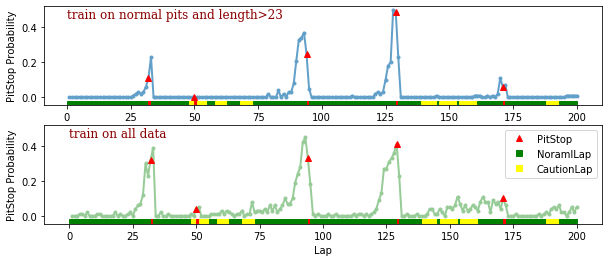

In [161]:
#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

light_blue = '#62a0ca'
light_green = '#97cb97'
light_magenta = '#e597e5'

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

def add_status(axs,y=-0.04, height=0.02):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

lw=2
        
fig, axs = plt.subplots(2, 1, figsize=(10, 4))

rid = 'sel'
axs[0].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_blue ,label='', linewidth=lw)
axs[0].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[0].set_ylabel('PitStop Probability')
axs[0].set_xlabel('Lap')
add_status(axs[0])
axs[0].set_ylim((-0.045,0.52))
axs[0].text(0,0.45, 'train on normal pits and length>23',fontdict=font)

rid = 'all'
axs[1].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_green,label='', linewidth=lw)
axs[1].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[1].set_ylabel('PitStop Probability')
axs[1].set_xlabel('Lap')
add_status(axs[1])
axs[1].set_ylim((-0.045,0.52))
axs[1].text(0,0.45, 'train on all data',fontdict=font)


axs[1].plot([0],[-10],'s',color=green, label='NoramlLap', linewidth=lw)
axs[1].plot([0],[-10],'s',color=yellow, label='CautionLap', linewidth=lw)
plt.legend(prop={'size': 10})
plt.savefig('probility_output_pitmodel.pdf')

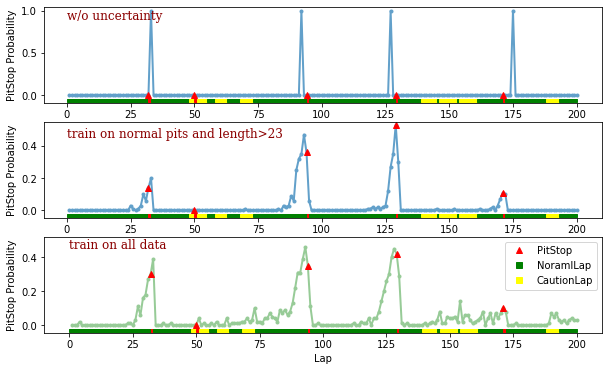

In [404]:
#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

light_blue = '#62a0ca'
light_green = '#97cb97'
light_magenta = '#e597e5'

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

def add_status(axs,y=-0.04, height=0.02):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

lw=2
        
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

rid = 'dsel'
axs[0].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_blue ,label='', linewidth=lw)
axs[0].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[0].set_ylabel('PitStop Probability')
axs[0].set_xlabel('Lap')
add_status(axs[0], y=-0.08, height=0.035)
axs[0].set_ylim((-0.045*2,1.05))
axs[0].text(0,0.9, 'w/o uncertainty',fontdict=font)


rid = 'sel'
axs[1].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_blue ,label='', linewidth=lw)
axs[1].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[1].set_ylabel('PitStop Probability')
axs[1].set_xlabel('Lap')
add_status(axs[1])
axs[1].set_ylim((-0.045,0.55))
axs[1].text(0,0.45, 'train on normal pits and length>23',fontdict=font)

rid = 'all'
axs[2].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_green,label='', linewidth=lw)
axs[2].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[2].set_ylabel('PitStop Probability')
axs[2].set_xlabel('Lap')
add_status(axs[2])
axs[2].set_ylim((-0.045,0.52))
axs[2].text(0,0.45, 'train on all data',fontdict=font)


axs[2].plot([0],[-10],'s',color=green, label='NoramlLap', linewidth=lw)
axs[2].plot([0],[-10],'s',color=yellow, label='CautionLap', linewidth=lw)
plt.legend(prop={'size': 10})
plt.savefig('probility_output_pitmodel.pdf')

## raw long prediction

In [166]:
pitmodel = PitModel()
#pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
#pitmodel.load_model('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
pitmodel.load_model('pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds)

init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


In [175]:
#fill template
targets[np.where(targets==999)] = 0
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0

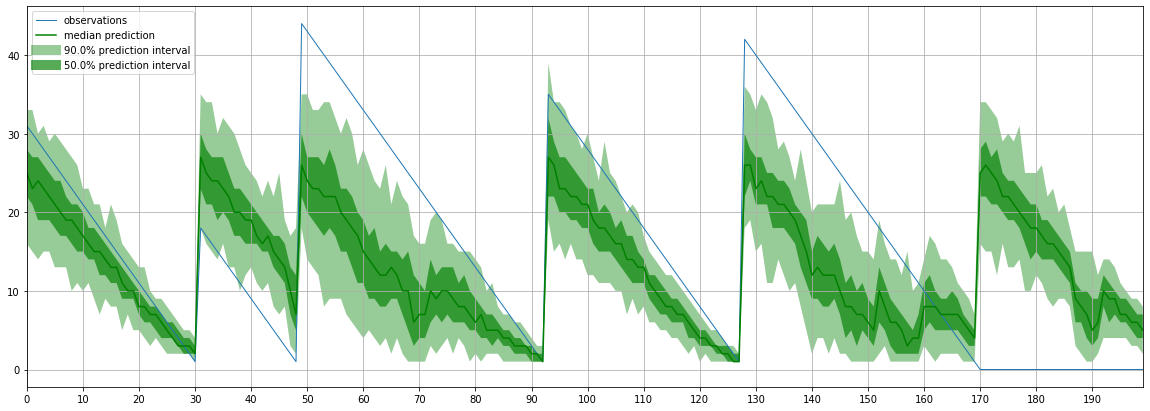

In [176]:
plot_prob_forecasts_ex([tss],[forecast],'')

In [174]:
targets[:-10]

array([ 31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,
        20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,
         9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,   1.,  18.,  17.,
        16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,   6.,
         5.,   4.,   3.,   2.,   1.,  44.,  43.,  42.,  41.,  40.,  39.,
        38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,  30.,  29.,  28.,
        27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,  18.,  17.,
        16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,   6.,
         5.,   4.,   3.,   2.,   1.,  35.,  34.,  33.,  32.,  31.,  30.,
        29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,
        18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,
         7.,   6.,   5.,   4.,   3.,   2.,   1.,  42.,  41.,  40.,  39.,
        38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,  30.,  29.,  28.,
        27.,  26.,  25.,  24.,  23.,  22.,  21.,  2

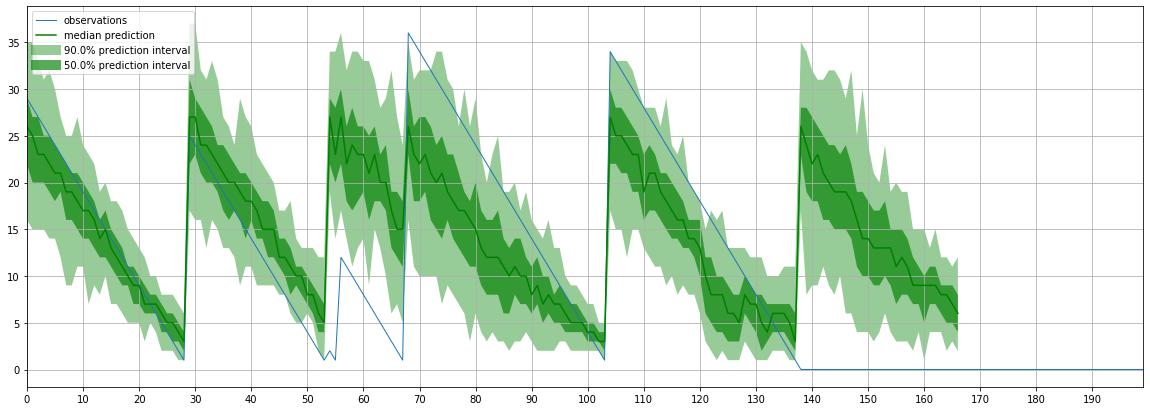

In [178]:
# check car12 in indy500-2017
test_car12 = df_train[(df_train['carno']==12) & (df_train['eid']==4)]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds)
#fill template
targets[np.where(targets==999)] = 0
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0
plot_prob_forecasts_ex([tss],[forecast],'')        

In [180]:
test_car12[(test_car12['lap']>50) & (test_car12['lap']<60)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
24516,3.0,0.0,22.0,1.0,12,4,51,25.0,0.0
24517,2.0,1.0,23.0,1.0,12,4,52,25.0,1.0
24518,1.0,2.0,24.0,1.0,12,4,53,25.0,2.0
24519,2.0,0.0,0.0,1.0,12,4,54,2.0,0.0
24520,1.0,1.0,1.0,1.0,12,4,55,2.0,1.0
24521,12.0,0.0,0.0,1.0,12,4,56,12.0,0.0
24522,11.0,1.0,1.0,1.0,12,4,57,12.0,1.0
24523,10.0,2.0,2.0,1.0,12,4,58,12.0,2.0
24524,9.0,2.0,3.0,1.0,12,4,59,12.0,0.0


init model:pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR:

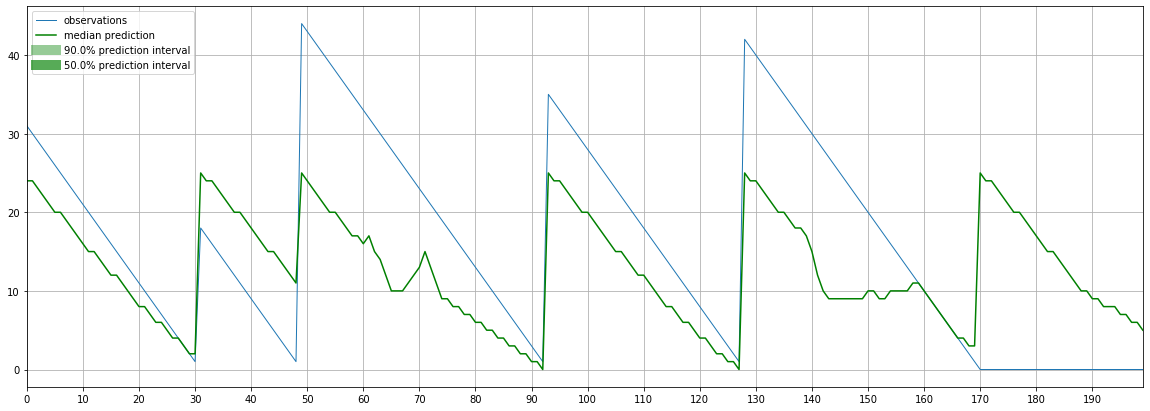

In [254]:
pitmodel = PitModel()
#pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
#pitmodel.load_model('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
pitmodel.load_model('pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle')
# check car12 in indy500-2017
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds[:,:3])
#fill template
targets[np.where(targets==999)] = 0
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0
plot_prob_forecasts_ex([tss],[forecast],'')    

## draw histgram of forecasting result

In [283]:
def draw_hist(forecast, targets, maxlap=200):
    
    histsum = np.zeros((maxlap))
    
    samples = forecast.samples
    print('sample shape:', samples.shape)
    
    samplecnt , totallap = samples.shape

    if totallap == maxlap:
        last_pitlap = np.where(targets == 999)[0][0]
        print('last pitlap:', last_pitlap)
    else:
        last_pitlap = totallap
    
    for lap in range(last_pitlap):
        pitlap_pred = lap + samples[:, lap]
        pitlap_idx = pitlap_pred.astype(int)
        
        #histsum[pitlap_idx] += 1
        for idx in pitlap_idx:
            if idx < maxlap:
                histsum[idx] += 1
    
    #normalize
    histsum /= samplecnt*totallap
    
    return histsum

In [264]:
pitmodel.load_model('pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle')
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds[:,:3])

init model:pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR: key 14-43 not found in model
ERROR:

In [265]:
h = draw_hist(forecast, targets)

sample shape: (100, 200)
last pitlap: 170


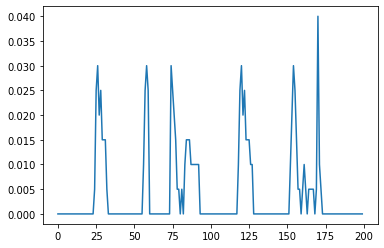

In [266]:
plt.plot(h)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
sample shape: (100, 200)
last pitlap: 170


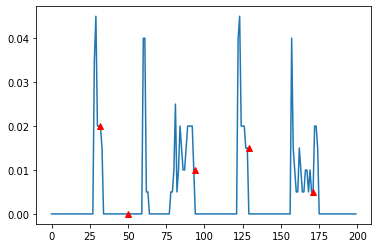

In [280]:
rid='sel'
pitmodel.load_model('pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle')
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds[:,:3])
h = draw_hist(forecast, targets)
plt.plot(h)

x= pit[rid][0,:].astype(int)
y = h[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
sample shape: (100, 200)
last pitlap: 170


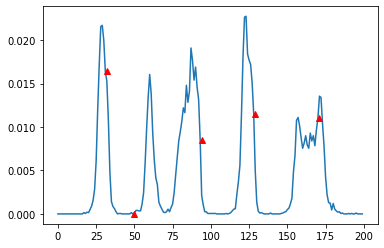

In [277]:
rid='sel'
pitmodel.load_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
forecast2,targets2 = pitmodel.forecast_onecar_lap2nextpit(test_ds)
h2 = draw_hist(forecast2, targets2)
plt.plot(h2)

x= pit[rid][0,:].astype(int)
y = h2[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

In [275]:
pit[rid][0,:].astype(int)

array([ 32,  50,  94, 129, 171])

In [289]:
test_plen2 = df_test[(df_test['lap2nextpit']==2)]
test_ds = test_plen2[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

test_car12 = df_test[(df_test['carno']==12) & (df_test['lap2nextpit']==2)]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
sample shape: (100, 5)


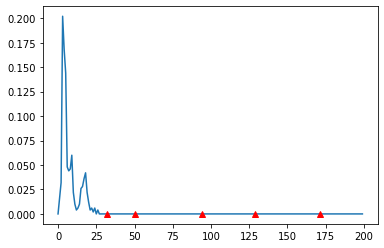

In [290]:
rid='sel'
pitmodel.load_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
forecast2,targets2 = pitmodel.forecast_onecar_lap2nextpit(test_ds)
h2 = draw_hist(forecast2, targets2)
plt.plot(h2)

x= pit[rid][0,:].astype(int)
y = h2[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle
sample shape: (100, 5)


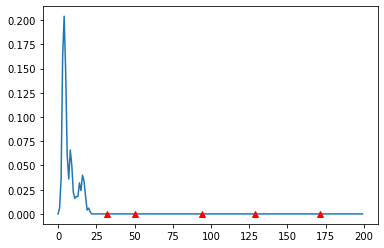

In [292]:
rid='sel'
pitmodel.load_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle')
forecast2,targets2 = pitmodel.forecast_onecar_lap2nextpit(test_ds)
h2 = draw_hist(forecast2, targets2)
plt.plot(h2)

x= pit[rid][0,:].astype(int)
y = h2[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

init model:pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle
sample shape: (100, 5)


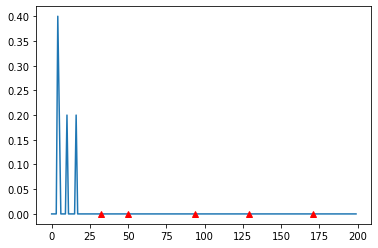

In [291]:
pitmodel.load_model('pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle')
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds[:,:3])
h = draw_hist(forecast, targets)
plt.plot(h)

x= pit[rid][0,:].astype(int)
y = h[x-1]
plt.plot(x,y,'^',color='r', label='PitStop', linewidth=lw)

## test

In [101]:
prob['noshort'][0,:]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [78]:
pitmodel = PitModel()
#pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
#pitmodel.load_model('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
pitmodel.load_model('pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

forecast,targets = pitmodel.forecast_onecar(test_ds)



init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


In [79]:
pitidx = np.where(targets==1)
pits = targets[pitidx]

In [80]:
#fill template
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0


In [81]:
tss.iloc[31,0]

1.0

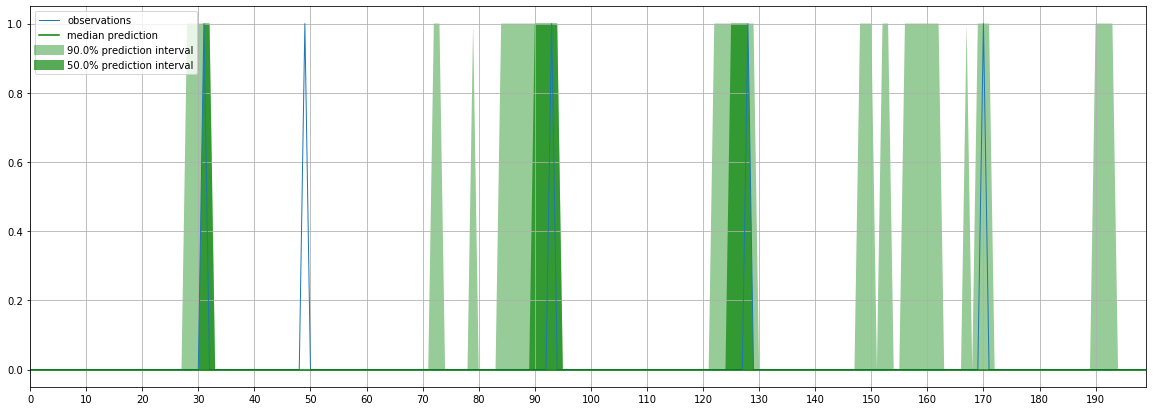

In [82]:
plot_prob_forecasts_ex([tss],[forecast],'')

In [83]:
pred = np.mean(forecast.samples, axis=0)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.03, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.02, 0.01, 0.04, 0.04, 0.15, 0.23, 0.22, 0.3 , 0.32,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.02, 0.03, 0.03, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01,
       0.02, 0.01, 0.03, 0.03, 0.05, 0.05, 0.1 , 0.11, 0.02, 0.05, 0.05,
       0.01, 0.01, 0.1 , 0.05, 0.01, 0.01, 0.04, 0.06, 0.12, 0.14, 0.09,
       0.2 , 0.25, 0.26, 0.27, 0.3 , 0.29, 0.33, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.03, 0.01, 0.04, 0.03,
       0.04, 0.17, 0.14, 0.24, 0.38, 0.33, 0.41, 0.47, 0.2 , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.02,
       0.  , 0.04, 0.01, 0.01, 0.03, 0.06, 0.1 , 0.

Text(0.5, 0, 'Lap')

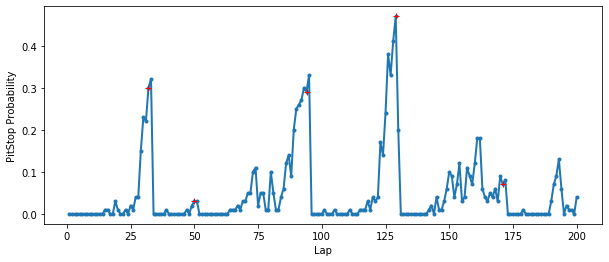

In [86]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
#axs.plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
#axs.plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
#axs.plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)
x = np.arange(len(pred)) + 1
axs.plot(x, pred,'.-',label='PitStop', linewidth=2)

x = pitidx[0].reshape(-1)
y = np.zeros_like(x)
y = pred[x]
#axs.scatter(x,y,color='r')
#,'+',color='r', label='PitStopX')
axs.plot(x+1,y,'+',color='r', label='PitStopX', linewidth=2)
axs.set_ylabel('PitStop Probability')
axs.set_xlabel('Lap')

In [78]:
x.shape

(5,)

In [80]:
y.shape

(5,)

In [69]:
pitidx[0]

array([ 31,  49,  93, 128, 170])

In [196]:
test_car12[(test_car12['lap']>24) & (test_car12['lap']<33)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
24490,4.0,0.0,26.0,0.0,12,4,25,29.0,0.0
24491,3.0,0.0,27.0,0.0,12,4,26,29.0,0.0
24492,2.0,0.0,28.0,0.0,12,4,27,29.0,0.0
24493,1.0,0.0,29.0,0.0,12,4,28,29.0,0.0
24494,25.0,0.0,0.0,1.0,12,4,29,25.0,0.0
24495,24.0,0.0,1.0,1.0,12,4,30,25.0,0.0
24496,23.0,0.0,2.0,1.0,12,4,31,25.0,0.0
24497,22.0,0.0,3.0,1.0,12,4,32,25.0,0.0


In [103]:
test_car12[(test_car12['lap']>45) & (test_car12['lap']<53)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1227,3.0,0.0,15.0,1.0,12,5,46,18.0,0.0
1228,2.0,1.0,16.0,1.0,12,5,47,18.0,1.0
1229,1.0,2.0,17.0,1.0,12,5,48,18.0,2.0
1230,44.0,0.0,0.0,0.0,12,5,49,44.0,0.0
1231,43.0,1.0,1.0,0.0,12,5,50,44.0,1.0
1232,42.0,2.0,2.0,0.0,12,5,51,44.0,2.0
1233,41.0,3.0,3.0,0.0,12,5,52,44.0,3.0


In [37]:
pred[45:55]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
pred.shape

(202,)

In [64]:
test_ds

array([[31.,  0.,  1.,  0.],
       [30.,  0.,  2.,  0.],
       [29.,  0.,  3.,  0.],
       [28.,  0.,  4.,  0.],
       [27.,  0.,  5.,  0.],
       [26.,  0.,  6.,  0.],
       [25.,  0.,  7.,  0.],
       [24.,  0.,  8.,  0.],
       [23.,  0.,  9.,  0.],
       [22.,  0., 10.,  0.],
       [21.,  0., 11.,  0.],
       [20.,  0., 12.,  0.],
       [19.,  0., 13.,  0.],
       [18.,  0., 14.,  0.],
       [17.,  0., 15.,  0.],
       [16.,  0., 16.,  0.],
       [15.,  0., 17.,  0.],
       [14.,  0., 18.,  0.],
       [13.,  0., 19.,  0.],
       [12.,  0., 20.,  0.],
       [11.,  0., 21.,  0.],
       [10.,  0., 22.,  0.],
       [ 9.,  0., 23.,  0.],
       [ 8.,  0., 24.,  0.],
       [ 7.,  0., 25.,  0.],
       [ 6.,  0., 26.,  0.],
       [ 5.,  0., 27.,  0.],
       [ 4.,  0., 28.,  0.],
       [ 3.,  0., 29.,  0.],
       [ 2.,  0., 30.,  0.],
       [ 1.,  0., 31.,  0.],
       [18.,  0.,  0.,  0.],
       [17.,  0.,  1.,  0.],
       [16.,  0.,  2.,  0.],
       [15.,  

In [107]:
model['sel'].predict(1,16,1)

15.0

In [117]:
def testmodel(rid):
    pitmodel = model[rid]
    samples = np.zeros((1000))
    for i in range(1000):
        samples[i] = pitmodel.predict(1,16,1)

    print('min:', np.min(samples))
    print('<5:', np.sum(samples<=5))
    print('prob(plen=2) = ', np.sum(samples==2)/1000)
    return samples

In [118]:
s = testmodel('sel')

min: 3.0
<5: 4
prob(plen=2) =  0.0


In [119]:
s = testmodel('all')

min: 1.0
<5: 157
prob(plen=2) =  0.025


In [120]:
s = testmodel('noshort')

min: 1.0
<5: 148
prob(plen=2) =  0.017
